# 1 Import packages and load methods

In [16]:
import Ipynb_importer

In [18]:
import TrodesReader
# import from https://bitbucket.org/mkarlsso/trodes/src/master/ or pip install trodesnetwork
from collections import deque
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
from pprint import pprint
import scipy

In [19]:
def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    if filter_name == 'elliptical':
        sos = signal.ellip(order, 0.01, 120, [lowcut, highcut], btype='bp', output='sos', fs=sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

    y = signal.sosfiltfilt(sos, flattened_array)

    return y

In [35]:
def hilbert_processing(power_data):
    '''
    @param power_data: raw power array
    @return hilbert_magnitude: magnitude envelope of power_data after hilbert transformation
    '''
    hilbert_analytic = scipy.signal.hilbert(power_data)
    hilbert_magnitude = np.abs(hilbert_analytic)
                    
    return hilbert_magnitude

In [61]:
def denoise(power_data, time_data, noise_label, threshold):
    '''
    @param power_data:
    @param time_data:
    @param noise_label:
    @param threshold:
    
    @return denoied:
    @retun denoised_time
    '''
    if((len(power_data)!=len(time_data)) or (len(power_data))!=len(noise_data)):
        raise ValueError('Power array, time array and noise label array should all have the same length')
    
    denoised = []
    denoised_time = []
    for i in range(0,len(power_data)):
        if ((not noise_label[i]) and (power_data[i]<=threshold)):
            denoised.append(power_data[i])
            denoised_time.append(time_data[i])
    
    return denoised, denoised_time

In [69]:
def detect(magnitude, num_std, num_wait):
    '''
    @param magnitude: power array for threshold-crossing events detection
    @param num_std: number of standard deviation above average (of power array) for threshold to be
    @param num_wait: the number of samples to wait before stimulating. i.e num_wait consecutive Trues then stimulate
    
    @return stimulation: numpy array of stimulation status (T/F) at each sample point in power array
    '''
    if(len(magnitude)==0 or (len(magnitude)<num_wait)):
        raise ValueError('Length of array magnitude is 0, or its length is smaller than wait buffer')
    
    avg = np.mean(magnitude)
    std = np.std(magnitude)
    threshold = avg + std*num_std
    decision = [False]*(num_wait-1)
    stimulation = []
    
    for i in range(0,len(magnitude)):
        decision.append(magnitude[i]>threshold)
        current_stimulation = True
        for m in range(len(decision)-num_wait,len(decision)):
            if not decision[m]:
                current_stimulation = False
        stimulation.append(current_stimulation)
    
    return np.array(stimulation)

In [37]:
def calculate_rms(buffer):
    """
    return the root mean-squared of a given array
    @param buffer: any array or list of number

    @return: the root mean-squared value of the array as a proxy for its power
    """
    if(len(buffer)==0):
        raise ValueError('Array has length zero')
    
    square_summed = 0
    for k in buffer:
        square_summed += (k**2)
    
    return math.sqrt(square_summed/len(buffer))

In [38]:
def online_rms_processing(power_data, sampling_rate, time_data, buffer_length, lower_bound, upper_bound, threshold):
    '''
    @param power_data: array of raw power across time
    @param sampling_rate: 
    @param time_data: array of power_data's timestamps in seconds
    @param buffer_length: number of data samples for RMS estimation
    @param lower_bound: lower bound of target frequency range 
    @param upper_bound: upper bound of target frequency range
    @param threshold: maximum RMS value to be considered
    
    @return rms_magnitude: array of RMS-processed power series
    @return rms_time: array of rms_magnitude's timestamps in seconds
    '''
    if(len(power_data)!=len(time_data)):
        raise ValueError('Power array and time array should have the same length')
    if(len(power_data)<buffer_length):
        raise ValueError('Power array can\'t be shorted than buffer length')
    
    rms_magnitude = []
    rms_time = []
    for i in range(buffer_length-1,len(power_data)):
        current_buffer = power_data[i-buffer_length+1:i]
        current_filtered = bandpass_filter('butterworth', current_buffer, lfp_sampling_rate, 1, lower_bound, upper_bound)
        current_rms = calculate_rms(current_filtered)
        if(current_rms<=threshold):
            rms_magnitude.append(current_rms)
            rms_time.append(time_data[i])
    
    return rms_magnitude, rms_time

In [39]:
def offline_rms_processing(power_data, time_data, buffer_length, threshold):
    '''
    @param power_data: array of raw power across time
    @param time_data: array of power_data's timestamps in seconds
    @param buffer_length: number of data samples for RMS estimation
    @param threshold: maximum RMS value to be considered
    
    @return rms_magnitude: array of RMS-processed power series
    @return rms_time: array of rms_magnitude's timestamps in seconds
    '''
    if(len(power_data)!=len(time_data)):
        raise ValueError('Power array and time array should have the same length')
    if(len(power_data)<buffer_length):
        raise ValueError('Power array can\'t be shorted than buffer length')
    
    rms_magnitude = []
    rms_time = []
    for i in range(buffer_length-1,len(power_data)):
        current_buffer = power_data[i-buffer_length+1:i]
        current_rms = calculate_rms(current_buffer)
        if(current_rms<=threshold):
            rms_magnitude.append(current_rms)
            rms_time.append(time_data[i])
            
    return rms_magnitude, rms_time

In [41]:
def extract_events(stimulation, timestamps):
    
    if(len(stimulation)!=len(timestamps)):
        raise ValueError('stimulation array and timestamps array must have the same length')
    
    changedtime = []
    eventduration = []
    truetime = []
    for i in range(1,len(stimulation)):
        previous = stimulation[i-1]
        if previous != stimulation[i]:
            changedtime.append(timestamps[i])
            
    for i in range(0,len(changedtime)-1,2):
        eventduration.append((changedtime[i+1]-changedtime[i])*1000)
        
    for i in range(0,len(changedtime),2):
        truetime.append(changedtime[i])
    
    return np.array(changedtime), np.array(eventduration), np.array(truetime)

In [42]:
def deblip_with_duration(truetime,eventduration,threshold):
    
    if(len(truetime)!=len(eventduration)):
        raise ValueError('truetime array and eventduration must have the same length')
        
    deblipped = []
    for i in range(0,len(truetime)):
        if(eventduration[i]>=threshold):
            deblipped.append(truetime[i])
    
    return np.array(deblipped)

In [43]:
def deblip_with_frequency(truetime,threshold):
    deblipped = []
    deblipped.append(truetime[0])
    for i in range(1,len(truetime)):
        if((truetime[i]-truetime[i-1])>threshold):
            deblipped.append(truetime[i])
            
    return np.array(deblipped)

In [44]:
def accuracy_precision_calculation(detection_series_1, detection_series_2, window_width):
    '''
    detection_series_2 is used as ground truth reference to calculate the accuracy and precision of detection_series_1. 
    For a particular event in detection_series_2, if there exists an event in detection_series_1 that matches the one
    in series_2, we mark the one in series_2 (ground truth) as detected and the one in series_1 as truepositive (TP). 
    If an event in series_1 doesn't match any series_2 event, it's marked as falsepositive(FP).
    
    @param detection_series_1: timestamp (of the starts of events) arrays in seconds 
    @param detection_series_2: timestamp (of the starts of events) arrays in seconds
    
    @param window_width: range of detection time difference allowed
    @return accuracy: percentage of series_2 events detected in series_1
    @return precision: percentage of correct detections (TP) in series_1
    @return (len(detection_series_2)-len(truepositive)): number of series_2 events unmatched by any series_1 event
    '''
    truepositive = []
    falsepositive = []
    for i in range(0,len(detection_series_1)):
        cnt = 0
        for j in range(0,len(offline_detections)):
            if(abs(detection_series_1[i]-detection_series_2[j])<window_width):
                break
            cnt += 1
        if(cnt<len(offline_detections)):
            truepositive.append(detection_series_1[i])
        else:
            falsepositive.append(detection_series_1[i])

    try:
        accuracy = (len(truepositive)/len(detection_series_2))*100
    except ZeroDivisionError:
        accuracy = 0
    try:
        precision = (len(truepositive)/(len(truepositive)+len(falsepositive)))*100
    except ZeroDivisionError:
        precision = 0
    
    return accuracy, precision, (len(detection_series_2)-len(truepositive))

# 2 Load Data and Initial Processing

## 2.1 Load Data

In [30]:
# this is the 40 min data : 20211207_E1_124311 
# nTrode used: 28

# Sameera's data path
'''
data_path_28 = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt28ch1.dat'
data_path_27 = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt27ch1.dat'
data_path_29 = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt29ch1.dat'
time_path = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.timestamps.dat'
'''

# Jhan's data path
data_path_28 = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.LFP_nt28ch1.dat"
data_path_27 = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.LFP_nt27ch1.dat"
data_path_29 = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.LFP_nt29ch1.dat"
time_path = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.timestamps.dat"

In [31]:
# this is the 40 min data : 20211207_E1_124311 
# nTrode used: 28

data = TrodesReader.readTrodesExtractedDataFile(data_path_28)
#pprint(data)
time = TrodesReader.readTrodesExtractedDataFile(time_path)
#pprint(time)

<string>:69: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


## 2.2 Convert time frame

In [32]:
start_time = int(time['first_timestamp'])
time_data = []
for i in time['data']:
    time_data.append((i[0]-start_time)/30000)

## 2.3 Parameters and Filtering

In [33]:
lfp_sampling_rate = 1500
lfp_sampling_period = (1/lfp_sampling_rate)*(10**9)

sw_lower = 5
sw_upper = 15
ripple_lower = 150
ripple_upper = 250

offline_hilbert_numstd = 9
noise_numstd = 5
offline_rms_numstd = 3
online_rms_numstd = 3

In [34]:
all_data = data['data']
lfp_data = []
for i in all_data:
    lfp_data.append(i[0])

ripple_lfp_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
noise_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, 500, 600)

# 3 Offline&Noise Processing with Hilbert

## 3.1 Hilbert Transform

In [45]:
offline_hilbert_magnitude = hilbert_processing(ripple_lfp_data)
noise_hilbert_magnitude = hilbert_processing(noise_data)

<IPython.core.display.Javascript object>


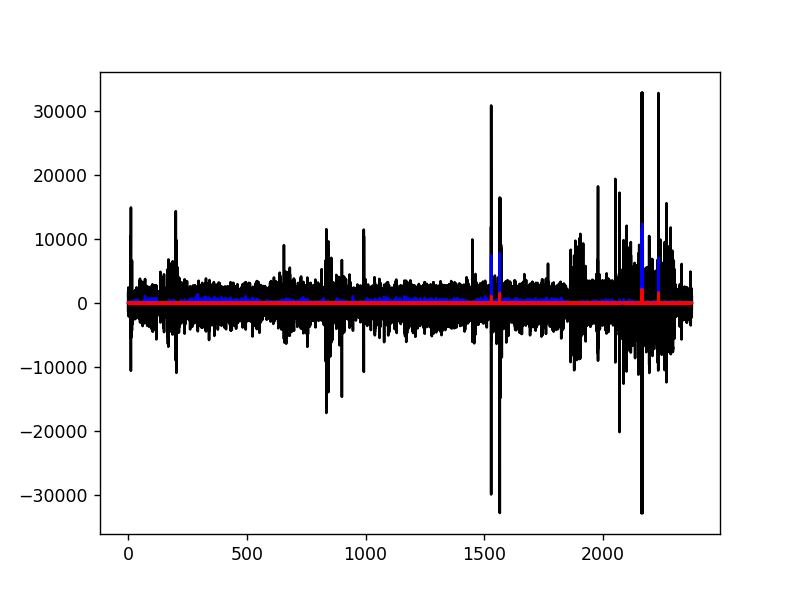

In [46]:
#Ripple-range data, Noise-range data against Raw Data (with Hilbert)
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='k',label='Raw Data')
plt.plot(time_data,offline_hilbert_magnitude,color='b',label='Ripple Range Hilbert')
plt.plot(time_data,noise_hilbert_magnitude,color='r',label='Noise Range Hilbert')
plt.show()

## 3.2 Noise Events Detection

In [70]:
noise_hilbert_decarr = detect(noise_hilbert_magnitude, noise_numstd, 1)

## 3.3 Offline(Hilbert) Denoising

In [72]:
offline_hilbert_denoised_results = denoise(offline_hilbert_magnitude, time_data, noise_hilbert_decarr, 1000)
offline_hilbert_denoised = offline_hilbert_denoised_results[0]
offline_hilbert_time = offline_hilbert_denoised_results[1]

## 3.4 Offline(Hilbert) Detection

### 3.4.1 Detect with Denoised Offline(Hilbert) Data

In [76]:
offline_hilbert_stimarr = detect(offline_hilbert_denoised, offline_hilbert_numstd, 3)

<IPython.core.display.Javascript object>


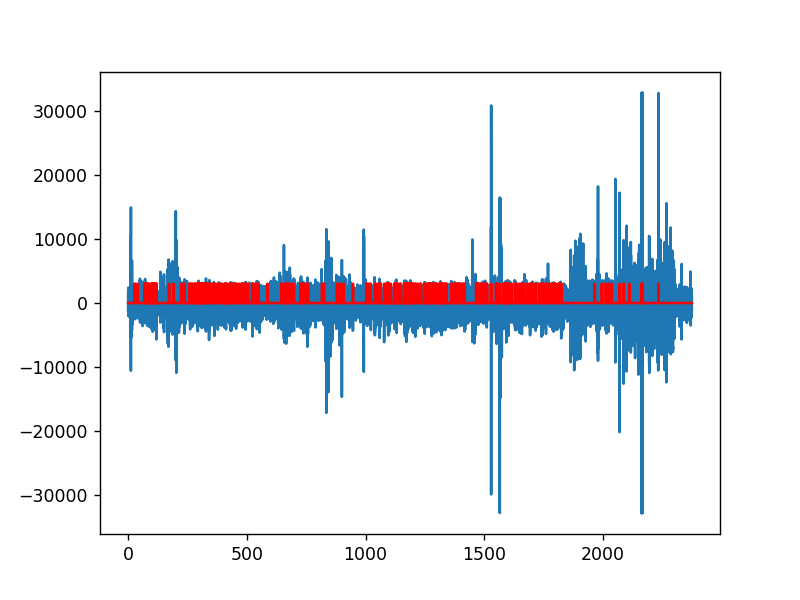

In [77]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,label='Raw Data')
plt.plot(offline_hilbert_time,offline_hilbert_stimarr*3000,color='r',label='Offline(Hilbert) Decision')
plt.show()

### 3.4.2 Detect with Offline(Hilbert) Data (no denoising)

In [78]:
offline_hilbert_stimarr_raw = detect(offline_hilbert_magnitude, offline_hilbert_numstd, 3)

<IPython.core.display.Javascript object>


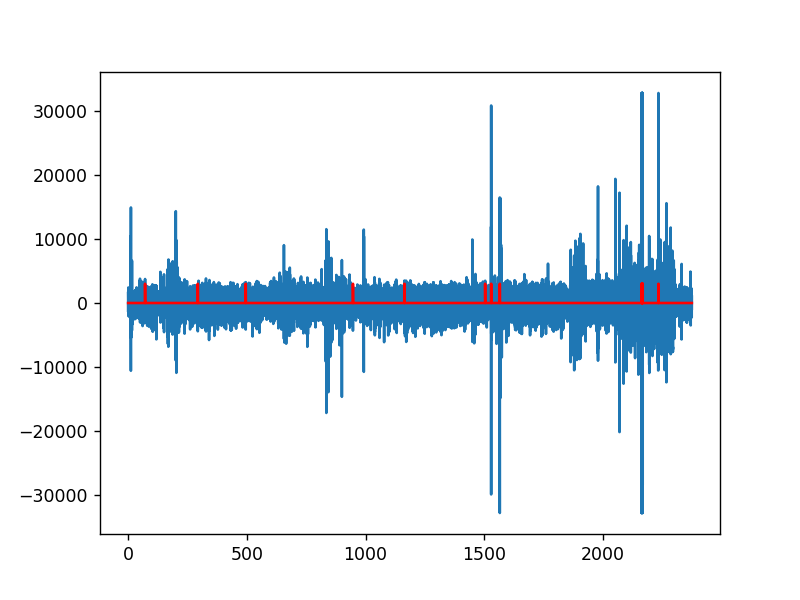

In [79]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,label='Raw Data')
plt.plot(time_data,offline_hilbert_stimarr_raw*3000,color='r',label='Offline(Hilbert) Decision')
plt.show()

## 3.5 Offline(Hilbert) Deblipping

### 3.5.1 Deblipping denoised Offline(Hilbert) data

In [83]:
hilbert_events_results = extract_events(offline_hilbert_stimarr,offline_hilbert_time)
offline_hilbert_changedtime = hilbert_events_results[0]
offline_hilbert_eventduration = hilbert_events_results[1]
offline_hilbert_truetime = hilbert_events_results[2]

In [86]:
offline_hilbert_deblipped = deblip_with_frequency(offline_hilbert_truetime,0.1)

<IPython.core.display.Javascript object>


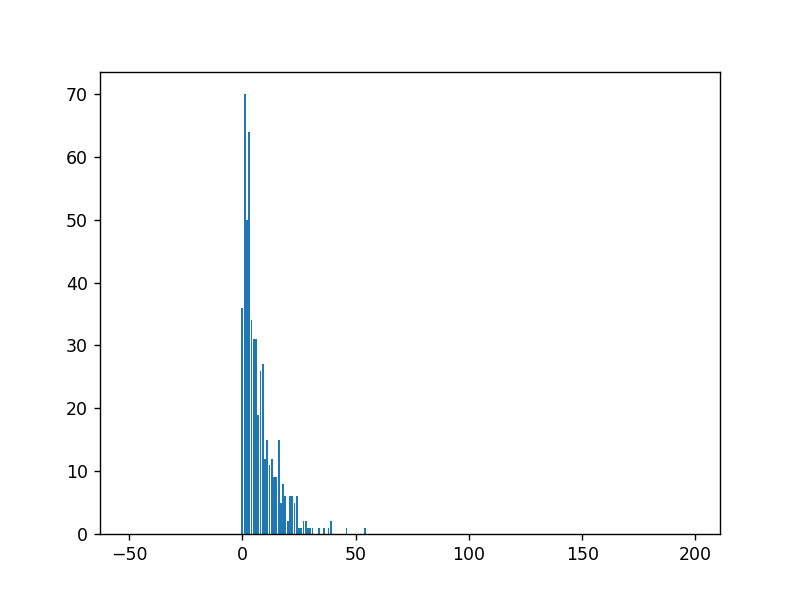

In [84]:
diffbar_hilbert, bin_edges_hilbert = np.histogram(offline_hilbert_eventduration, range(-50,200))
plt.figure()
plt.bar(bin_edges_hilbert[:-1],diffbar_hilbert)
plt.show()

<IPython.core.display.Javascript object>


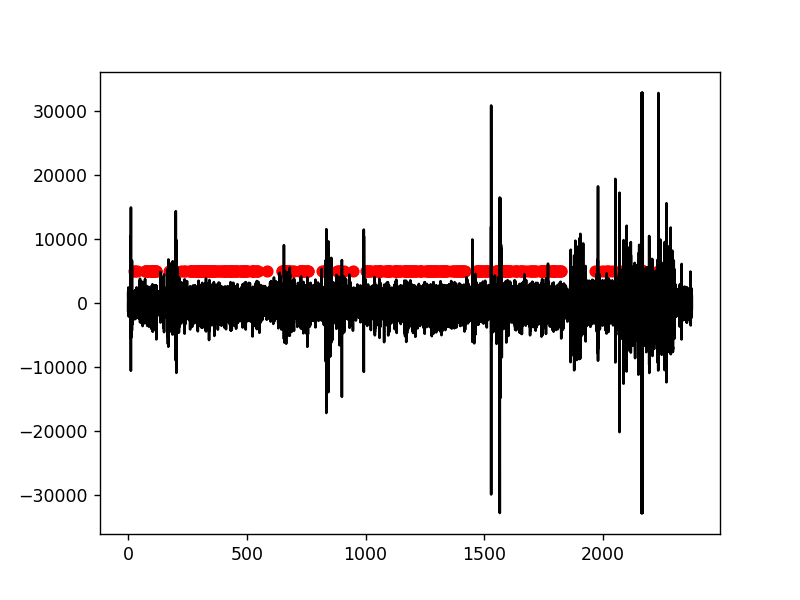

In [87]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='k')
#plt.plot(time_data,ripple_lfp_data,color='b')
plt.scatter(offline_hilbert_deblipped,np.array([True]*len(offline_hilbert_deblipped))*5000,color='r')
plt.show()

### 3.5.2 Deblipping Offline(Hilbert) data (no denoising)

In [90]:
hilbert_events_results_raw = extract_events(offline_hilbert_stimarr_raw,time_data)
offline_hilbert_changedtime_raw = hilbert_events_results_raw[0]
offline_hilbert_eventduration_raw = hilbert_events_results_raw[1]
offline_hilbert_truetime_raw = hilbert_events_results_raw[2]

In [91]:
offline_hilbert_deblipped_raw = deblip_with_frequency(offline_hilbert_truetime_raw,0.1)

<IPython.core.display.Javascript object>


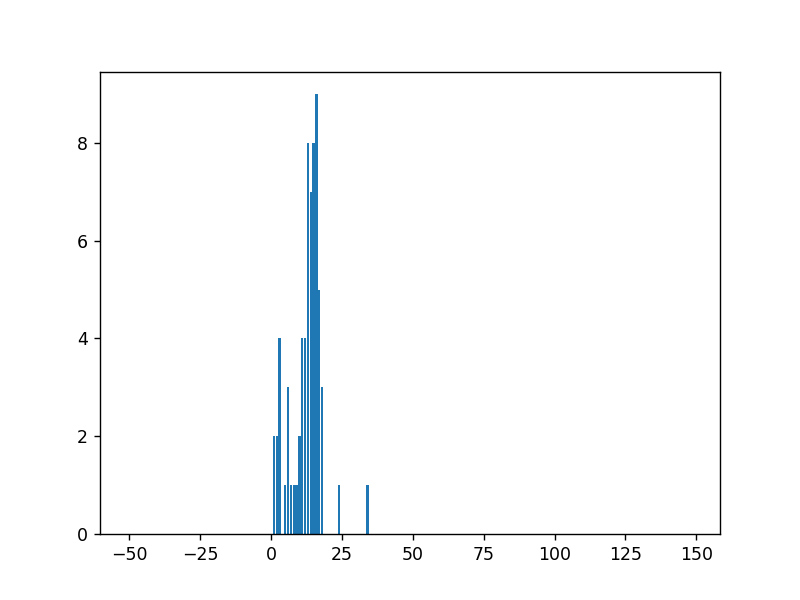

In [92]:
diffbar_raw, bin_edges_raw = np.histogram(offline_hilbert_eventduration_raw, range(-50,150))
plt.figure()
plt.bar(bin_edges_raw[:-1],diffbar_raw)
plt.show()

<IPython.core.display.Javascript object>


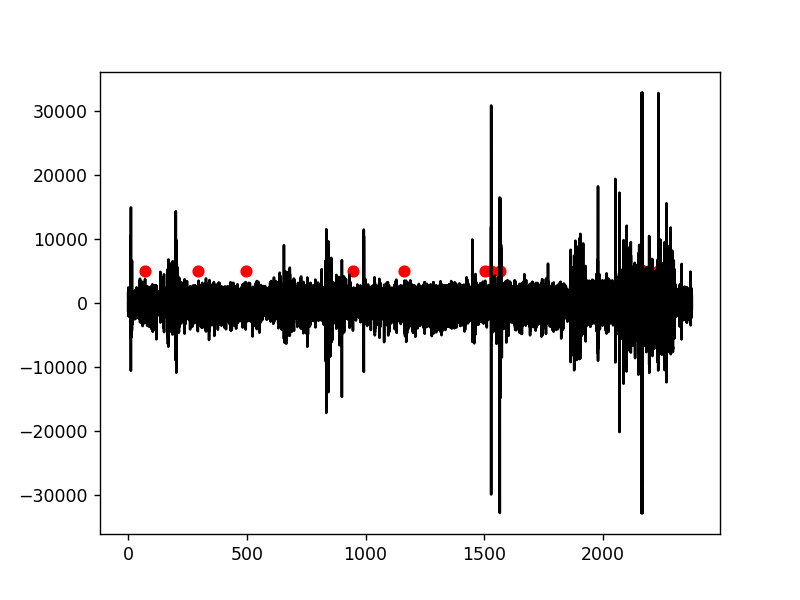

In [93]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='k')
#plt.plot(time_data,ripple_lfp_data,color='b')
plt.scatter(offline_hilbert_deblipped_raw,np.array([True]*len(offline_hilbert_deblipped_raw))*5000,color='r')
plt.show()

# 4 Offline Processing with RMS

## 4.1 Offline RMS Processing (all ripple data)

In [97]:
offline_rms_processing_results = offline_rms_processing(ripple_lfp_data, time_data, 150, 300)
offline_rms_magnitude = offline_rms_processing_results[0]
offline_rms_time = offline_rms_processing_results[1]

<IPython.core.display.Javascript object>


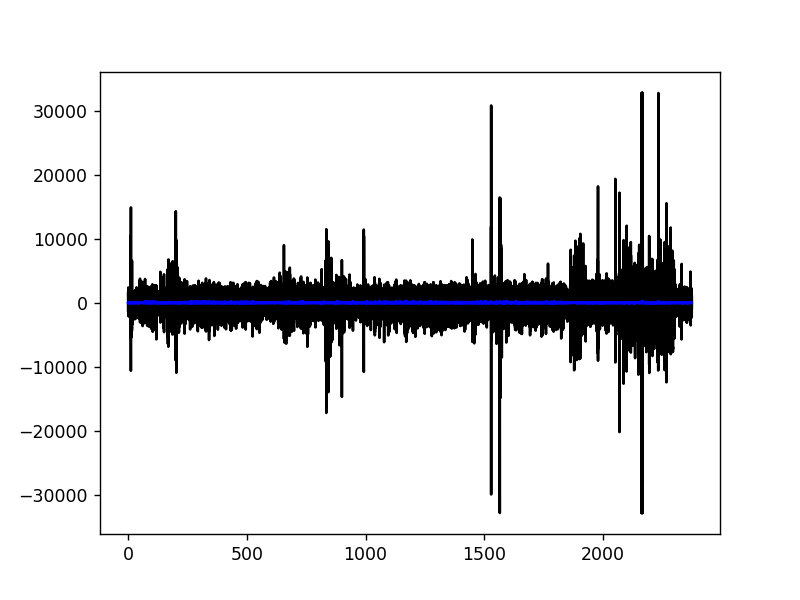

In [98]:
plt.figure()
plt.plot(time_data,lfp_data,color='k')
plt.plot(offline_rms_time,offline_rms_magnitude,color='b')

## 4.2 Offline(RMS) Detection

In [99]:
offline_rms_stimarr = detect(offline_rms_magnitude, offline_rms_numstd, 3)

<IPython.core.display.Javascript object>


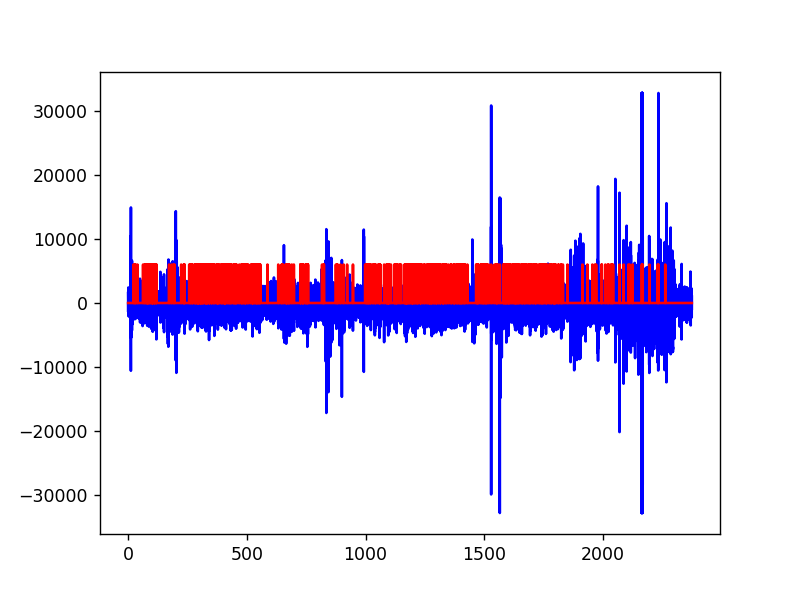

In [100]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='b')
plt.plot(offline_rms_time,offline_rms_stimarr*6000,color='r')
plt.show()

## 4.3 Offline(RMS) Deblipping

In [101]:
offline_rms_events_results = extract_events(offline_rms_stimarr,offline_rms_time)
offline_rms_changedtime = offline_rms_events_results[0]
offline_rms_eventduration = offline_rms_events_results[1]
offline_rms_truetime = offline_rms_events_results[2]

In [106]:
offline_rms_deblipped = deblip_with_duration(offline_rms_truetime,offline_rms_eventduration,100)

<IPython.core.display.Javascript object>


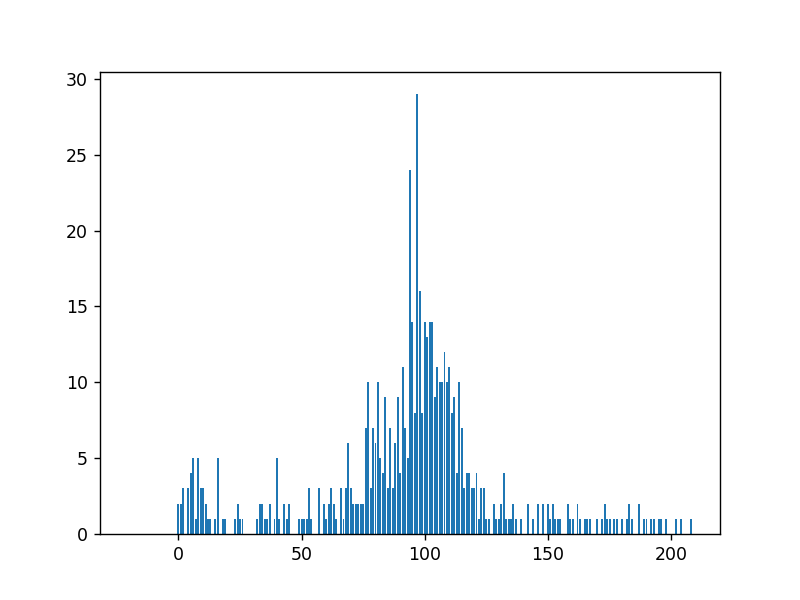

In [104]:
diffbar_rms, bin_edges_rms = np.histogram(offline_rms_eventduration, range(-20,210))
plt.figure()
plt.bar(bin_edges_rms[:-1],diffbar_rms)
plt.show()

<IPython.core.display.Javascript object>


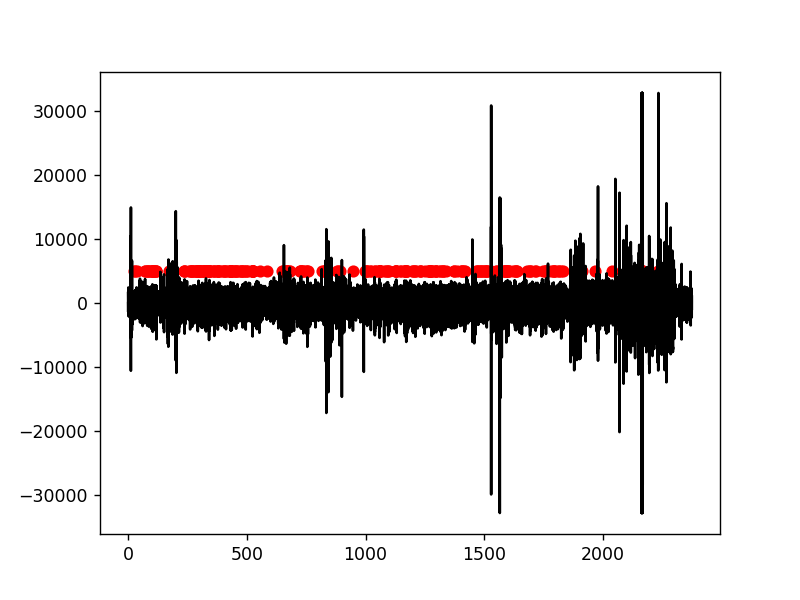

In [107]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='k')
#plt.plot(time_data,ripple_lfp_data,color='b')
plt.scatter(offline_rms_deblipped,np.array([True]*len(offline_rms_deblipped))*5000,color='r')
plt.show()

# 5 Online RMS Processing

## 5.1 Online RMS Processing

In [109]:
online_rms_results = online_rms_processing(lfp_data, lfp_sampling_rate, time_data, 150, ripple_lower, ripple_upper, 300)
online_rms_magnitude = online_rms_results[0]
online_rms_time = online_rms_results[1]

KeyboardInterrupt: 

## 5.2 Online RMS Detection

In [ ]:
online_rms_stimarr = detect(online_rms_magnitude, online_rms_numstd, 3)

In [ ]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data)
plt.plot(online_rms_time,online_rms_stimarr*6000,color='r',alpha=0.8)
plt.show()

## 5.3 Online RMS Deblipping

In [ ]:
online_rms_events_results = extract_events(online_rms_stimarr,online_rms_time)
online_rms_changedtime = online_rms_events_results[0]
online_rms_eventduration = online_rms_events_results[1]
online_rms_truetime = online_rms_events_results[2]

In [ ]:
online_rms_deblipped = deblip_with_duration(online_rms_truetime,online_rms_eventduration,100)

In [ ]:
diffbar_online, bin_edges_online = np.histogram(online_rms_eventduration, range(-20,200))
plt.figure()
plt.bar(bin_edges_online[:-1],diffbar_online)
plt.show()

In [ ]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='k')
#plt.plot(time_data,ripple_lfp_data,color='b')
plt.scatter(online_rms_deblipped,np.array([True]*len(online_rms_deblipped))*5000,color='r')
plt.show()

# 6 Accuracy and Precision

## 6.1 Online(RMS) vs. Offline(Hilbert)

In [ ]:
offline_hilbert_ap_results = accuracy_precision_calculation(online_rms_deblipped, offline_hilbert_deblipped, 0.03)
offline_hilbert_accuracy = offline_hilbert_ap_results[0]
offline_hilbert_precision = offline_hilbert_ap_results[1]
offline_hilbert_missed = offline_hilbert_ap_results[2]

## 6.2 Online(RMS) vs. Offline(Hilbert)_raw

In [ ]:
offline_hilbert_results_raw = accuracy_precision_calculation(online_rms_deblipped, offline_hilbert_deblipped_raw, 0.03)
offline_hilbert_accuracy_raw = offline_hilbert_ap_results_raw[0]
offline_hilbert_precision_raw = offline_hilbert_ap_results_raw[1]
offline_hilbert_missed_raw = offline_hilbert_ap_results_raw[2]

## 6.3 Online(RMS) vs. Offline(RMS)

In [ ]:
offline_rms_results = accuracy_precision_calculation(online_rms_deblipped, offline_rms_deblipped, 0.03)
offline_rms_accuracy = offline_rms_ap_results[0]
offline_rms_precision = offline_rms_ap_results[1]
offline_rms_missed = offline_rms_ap_results[2]

## 6.4 Overall Results

In [ ]:
plt.figure()
plt.plot(time_data,lfp_data,color='k')
plt.scatter(online_rms_deblipped,np.array([True]*len(online_rms_deblipped))*8000,color='r')
plt.scatter(offline_rms_deblipped,np.array([True]*len(offline_rms_deblipped))*6000,color='b')
plt.scatter(offline_hilbert_deblipped,np.array([True]*len(offline_hilbert_deblipped))*4000,color='g')

In [ ]:
x_data = ['Hilbert\nAccuracy','Hilbert(Raw)\nAccuracy','RMS\nAccuracy',
          'Hilbert\nPrecision','Hilbert(Raw)\nPrecision','RMS\nPrecision']
y_data = [round(offline_hilbert_accuracy),round(offline_hilbert_accuracy_raw),round(offline_rms_accuracy),
       round(offline_hilbert_precision),round(offline_hilbert_precision_raw),round(offline_rms_precision)]

plt.figure()
plt.bar(x_data,
       y_data,
       color=['r','r','r','b','b','b'])
'''
for x_label, y_label, label in zip(x_label, y_data,y_data):
    plt.text(x_label,
             y_label,
             label,
             ha='center', 
             va='bottom')
'''
plt.title('Accuracy and Precision')
plt.show()

In [ ]:
print('offline_hilbert_numstd = '+str(offline_hilbert_numstd))
print('noise_hilbert_numstd = '+str(noise_hilbert_numstd))
print('offline_rms_numstd = '+str(offline_rms_numstd))
print('online_rms_numstd = '+str(online_rms_numstd))
print('# of events with Offline(Hilbert)_denoised: '+str(len(offline_hilbert_truetime)))
print('# of events with Offline(Hilbert)_denoised_deblipped: '+str(len(offline_hilbert_deblipped)))
print('# of events with Offline(Hilbert)_raw: '+str(len(offline_hilbert_truetime_raw)))
print('# of events with Offline(Hilbert)_raw_deblipped: '+str(len(offline_hilbert_deblipped_raw)))
print('# of events with Offline(RMS): '+str(len(offline_rms_truetime)))
print('# of events with Offline(RMS)_deblipped: '+str(len(offline_rms_deblipped)))
print('# of events with Online(RMS): '+str(len(online_rms_truetime)))
print('# of events with Online(RMS)_deblipped: '+str(len(online_rms_deblipped)))
print('------------')
print('Accuracy with Offline(Hilbert): '+str(offline_hilbert_accuracy))
print('Precision with Offline(Hilbert): '+str(offline_hilbert_precision))
print('Accuracy with Offline(Hilbert)_raw: '+str(offline_hilbert_accuracy_raw))
print('Precision with Offline(Hilbert)_raw: '+str(offline_hilbert_precision_raw))
print('Accuracy with Offline(RMS): '+str(offline_rms_accuracy))
print('Precision with Offline(RMS): '+str(offline_rms_precision))

# 7 Lag Calculation

## 7.1 Cross Correlation - Offline(Hilbert) and Online(RMS)

In [ ]:
offline_hilbert_onlags = []
for i in range(len(online_rms_truetime)):
    for j in range(len(offline_hilbert_truetime)):
        offline_hilbert_onlags.append(round((online_rms_truetime[i]-offline_hilbert_truetime[j])*1000))

In [ ]:
offline_hilbert_xcorrhist, offline_hilbert_binedges = np.histogram(offline_hilbert_onlags,range(-200,200))
plt.figure()
plt.bar(offline_hilbert_binedges[:-1],offline_hilbert_xcorrhist)
plt.xlabel('Time Lag(ms)')
plt.ylabel('Cross Correlation')
plt.title('Online Stimulation Lag (%d Events, with Hilbert as Ground Truth)'%len(online_rms_truetime))

## 7.2 Cross Correlation - Offline(Hilbert)_raw and Online(RMS)

In [ ]:
offline_hilbert_onlags_raw = []
for i in range(len(online_rms_truetime)):
    for j in range(len(offline_hilbert_truetime_raw)):
        offline_hilbert_onlags_raw.append(round((online_rms_truetime[i]-offline_hilbert_truetime_raw[j])*1000))

In [ ]:
offline_hilbert_xcorrhist_raw, offline_hilbert_binedges_raw = np.histogram(offline_hilbert_onlags_raw,range(-200,200))
plt.figure()
plt.bar(offline_hilbert_binedges_raw[:-1],offline_hilbert_xcorrhist_raw)
plt.xlabel('Time Lag(ms)')
plt.ylabel('Cross Correlation')
plt.title('Online Stimulation Lag (%d Events, with Hilbert(Raw) as Ground Truth)'%len(online_rms_truetime))

## 7.3 Cross Correlation - Offline(RMS) and Online(RMS)

In [ ]:
offline_rms_onlags = []
for i in range(len(online_rms_truetime)):
    for j in range(len(offline_rms_truetime)):
        offline_rms_onlags.append(round((online_rms_truetime[i]-offline_rms_truetime[j])*1000))

In [ ]:
offline_rms_xcorrhist, offline_rms_binedges = np.histogram(offline_rms_onlags,range(-150,150))
plt.figure()
plt.bar(offline_rms_binedges[:-1],offline_rms_xcorrhist)
plt.xlabel('Time Lag(ms)')
plt.ylabel('Cross Correlation')
plt.title('Online Stimulation Lag (%d Events, with RMS as Ground Truth)'%len(online_rms_truetime))

# 8 Hyperparameter Sensitivity test

In [29]:
'''
The arbitrary parameters here are num_std for hilbert and num_std for rms
'''

# ------------------------- Hilbert -----------------------------------

hilbert_processing_results = offline_hilbert_processing(ripple_lfp_data,time_data,\
                                                        noise_hilbert_processing(Noise_data,5))
hilbert_denoised = hilbert_processing_results[0]
hilbert_time = hilbert_processing_results[1]
hilbert_avg = hilbert_processing_results[2]
hilbert_std = hilbert_processing_results[3]

In [32]:
# ------------------------- RMS -----------------------------------
rms_processing_results = online_rms_processing(lfp_data, lfp_sampling_rate, time_data,\
                                               150, ripple_lower, ripple_upper)
rms_magnitude = rms_processing_results[0]
rms_time = rms_processing_results[1]
rms_avg = rms_processing_results[2]
rms_std = rms_processing_results[3]

In [158]:
accuracy_matrix = np.zeros((8,8),dtype=float)
precision_matrix = np.zeros((8,8),dtype=float)
miss_matrix = np.zeros((8,8),dtype=float)

for i in range(1,9):
    rms_detection_results = online_rms_detection(rms_magnitude, rms_time, rms_avg, rms_std, i, 50)
    rms_deblipped = rms_detection_results[0]
    for j in range(5,13):
        hibert_detection_results = offline_hilbert_detection(hilbert_denoised, hilbert_time,\
                                                     hilbert_avg, hilbert_std, j, 0.1)
        hilbert_deblipped = hibert_detection_results[0]
        accuracy_precision_results = accuracy_precision_calculation(rms_deblipped, hilbert_deblipped, 0.03)
        
        accuracy_matrix[i-1,j-5] = accuracy_precision_results[0]
        precision_matrix[i-1,j-5] = accuracy_precision_results[1]
        miss_matrix[i-1,j-5] = accuracy_precision_results[2]

<IPython.core.display.Javascript object>


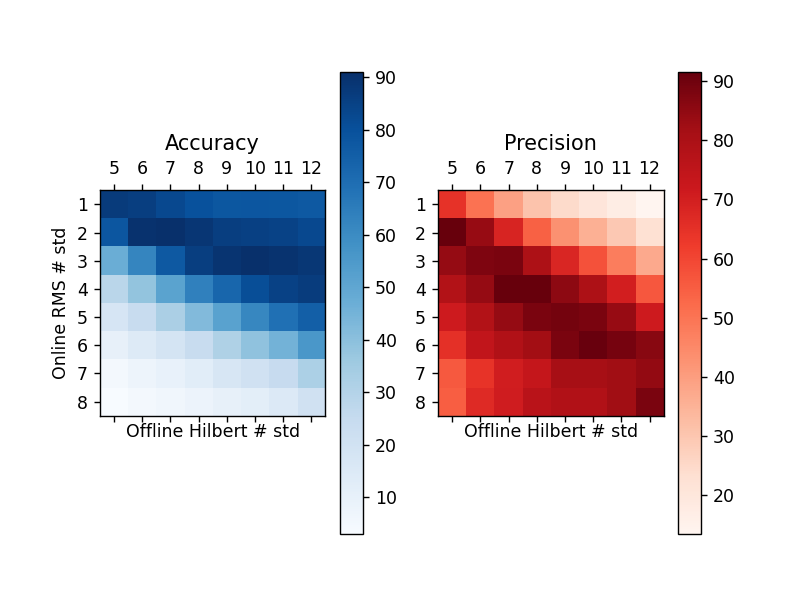

In [169]:
%matplotlib notebook
fig,(ax1,ax2) = plt.subplots(1,2)

ax_ylabels = []
ax_xlabels = []
for i in range(1,9):
    ax_ylabels.append(str(i))
    ax_xlabels.append(str(i+4))
    
ax1_mat = ax1.matshow(accuracy_matrix, cmap=plt.cm.Blues)  
ax1.set_yticks(np.linspace(0,7,8))
ax1.set_yticklabels(ax_ylabels)
ax1.set_xticks(np.linspace(0,7,8))
ax1.set_xticklabels(ax_xlabels)
ax1.set_xlabel('Offline Hilbert # std')
ax1.set_ylabel('Online RMS # std')
ax1.set_title('Accuracy')

ax2_mat = ax2.matshow(precision_matrix, cmap=plt.cm.Reds)
ax2.set_yticks(np.linspace(0,7,8)) 
ax2.set_yticklabels(ax_ylabels)
ax2.set_xticks(np.linspace(0,7,8))
ax2.set_xticklabels(ax_xlabels)
ax2.set_xlabel('Offline Hilbert # std')
#ax2.set_ylabel('Online RMS # std')
ax2.set_title('Precision')

fig.colorbar(ax1_mat,ax=ax1)
fig.colorbar(ax2_mat,ax=ax2)

<IPython.core.display.Javascript object>


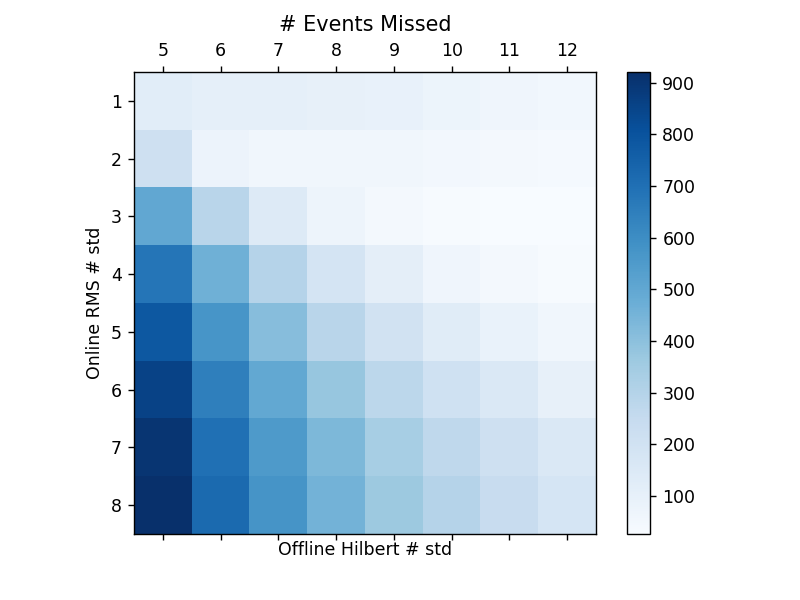

In [168]:
fig,ax3 = plt.subplots()

ax_ylabels = []
ax_xlabels = []
for i in range(1,9):
    ax_ylabels.append(str(i))
    ax_xlabels.append(str(i+4))
    
ax3_mat = ax3.matshow(miss_matrix, cmap=plt.cm.Blues)  
ax3.set_yticks(np.linspace(0,7,8))
ax3.set_yticklabels(ax_ylabels)
ax3.set_xticks(np.linspace(0,7,8))
ax3.set_xticklabels(ax_xlabels)
ax3.set_xlabel('Offline Hilbert # std')
ax3.set_ylabel('Online RMS # std')
ax3.set_title('# Events Missed')

fig.colorbar(ax3_mat,ax=ax3)